#**VOLCANOES ERUPTIONS DETECTION NETWORK**

# Google Drive connection to access the dataset
When executed it provides a **link to click** in order to get a temporary password (authorization code) to **fill the field**.

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Packages requirements

We need to install some packages before we can start:

In [ ]:
!rm -rf /content/ai4eo
!git clone https://github.com/ESA-PhiLab/ai4eo.git
!pip install -e /content/ai4eo/ -r /content/ai4eo/requirements.txt
!pip install imgaug

### Standard packages
Packages to do numerical computations, to use images, etc.

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from time import time
import pandas as pd
from skimage.io import imread

# Volcanoes eruption detection dataset 
### How the dataset has been created?
First of all we found a catalog containing all the information ragarding eruptions happened since 1999. 

In [ ]:
catalog = pd.read_csv('/content/drive/My Drive/volcanoes_detection/volcano_eruptions_from_1999_clean.csv')
catalog.head()

,start_time,Volcano Name,Latitude,Longitude
0,2019-06-26,Ulawun,-5.050,151.330
1,2019-06-24,Ubinas,-16.355,-70.903
2,2019-06-22,Raikoke,48.292,153.250
3,2019-06-11,"Fournaise, Piton de la",-21.244,55.708
4,2019-06-01,Great Sitkin,52.076,-176.130


The most important information is the **date**, in fact we discarded all the events happened before 2015 (when Sentinel 2 was launched). After that we created a **script that automatically dowloads** Sentinel 2 level 1-C products from **google earth engine platform**. The downloaded images are a cropped version of a "normal Sen2 image", in order to focus on volcanos we cut out a 10 by 10 km patch from the original image.  The last preprocessing step made is a **multispectral bands fusion** highlighting **infrared** information. An example of the final product is showed below.

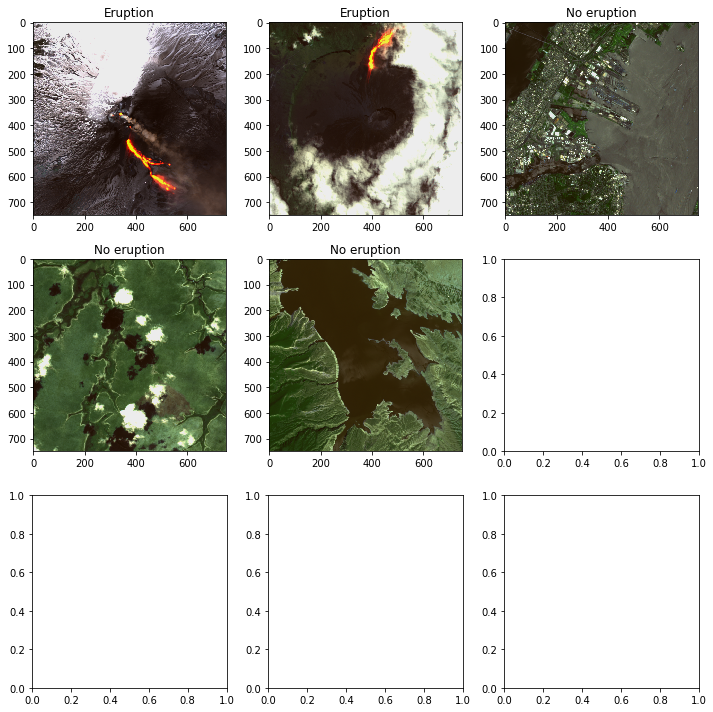

In [ ]:
images = {
    '/content/drive/My Drive/volcanoes_detection/data_reviewed/validation/eruption/Etna-2018-20170319T095021_20170319T095021_T33SVB.png': 'Eruption',
    '/content/drive/My Drive/volcanoes_detection/data_reviewed/validation/eruption/Fournaise, Piton de la-2016-09-11-20160914T063512_20160914T095616_T40KCB.png': 'Eruption',
    #'/content/drive/My Drive/volcanoes_detection/data_reviewed/validation/eruption/Barren Island-2018-09-25-20180918T040541_20180918T040745_T46PEU.png': 'Eruption',
    #'/content/drive/My Drive/volcanoes_detection/data_reviewed/training/Ubinas-2017-20190624T145731_20190624T150226_T19KBB.png': 'Eruption',
    #'/content/drive/My Drive/volcanoes_detection/data_reviewed/training/no_eruption/Fournaise, Piton de la-2019-06-11-20180601T063509_20180601T063505_T40KCB.png': 'No eruption',
    #'/content/drive/My Drive/volcanoes_detection/data_reviewed/training/no_eruption/Lat_-17.42105039_Lon_-62.27704286-2019-06-26-20180722T142039_20180722T142403_T20KNF.png': 'No eruption',
    '/content/drive/My Drive/volcanoes_detection/data_reviewed/training/no_eruption/NewYork-2019-06-26-20180630T154911_20180630T155933_T18TWL.png': 'No eruption',
    '/content/drive/My Drive/volcanoes_detection/data_reviewed/training/no_eruption/SerraGeralDoTocantinsEcologicalStation-2019-06-26-20180520T132241_20180520T132235_T23LLH.png': 'No eruption',
    '/content/drive/My Drive/volcanoes_detection/data_reviewed/training/no_eruption/Lat_42.94272116_Lon_46.91295157-2019-06-26-20180626T074731_20180626T075138_T38TPN.png': 'No eruption',
}

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10,10))
axes = axes.flatten()
for i, image in enumerate(images):
  axes[i].imshow(imread(image))
  axes[i].set_title(images[image])
fig.tight_layout()

### Dataset organization

- Master folder
  - Training folder
    - No eruption folder
    - Eruption folder
  - Validation folder
    - No eruption folder
    - Eruption folder
  - Testing folder
    - No eruption folder
    - Eruption folder
    
    
### Number of images
The dataset contains 1200 images in the training folder and 170 in the validation folder.

### **Images resizing and augmentation through Image Generator**


Now we can go on and do **Image Augmentation**.

Image Augmentation is a common technique in neural networks to increase the number of images in the dataset by applying particular changes on the available images. Common changes are image flipping and rotating, as well as brightness changing.

The Image Generator also helps in terms of **memory usage**.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

augmentator = ImageDataGenerator(
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=[0.3, 1.],
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='reflect',
)

Now we can create the input of the neural network by calling this function with these attributes:

*   path : the path where the dataset is
*   target size : the size
*   color mode : how we want to show the images
*   classes : the list of classes for our problem
*   class mode : the type of classes (in our case it is 'binary' because we have only two classes)
*   batch size : the number of images in each batch
*   shuffle : set to True to take random images


P.S.

The image labelling is made by splitting manually the images into different folders (called with the class name).

In [ ]:
from ai4eo.preprocessing import ImageLoader
import random

batch_size = 16
train_path = '/content/drive/My Drive/volcanoes_detection/data_reviewed/training/{label}/*.png'
val_path = '/content/drive/My Drive/volcanoes_detection/data_reviewed/validation/{label}/*.png'
#train_path = '/content/drive/My Drive/volcanoes_detection/training_dataset_color_corr'
#val_path = '/content/drive/My Drive/volcanoes_detection/validation_dataset_color_corr'
test_path = ' ' 

# We want to resize the images to 224x224 pixels. They are smaller to reduce 
# execution time but big enough to preserve features and patterns.
target_size = (512,512)

def scale_image(image):
  # Convert image to float (we cannot perform 
  # floating operations with unsigned integers)
  image = image.astype(float) / 255.
  image = np.clip(image, 0., 1.)

  # The Neural Network learns better if we zero-center all channels (RGB) and 
  # set the standard deviation to 1. We calculated these arbitray value as mean
  # and standard deviation of the complete training dataset:
  image -= np.array([0.44101639, 0.45513914, 0.40195001])
  image /= np.array([0.28792392, 0.29775171, 0.29840153])

  # We want to make the model more robust, so we randomly add some noise:
  if random.random() > 0.8:
    image += np.random.uniform(-0.1, 0.1, size=(512, 512))[..., np.newaxis]

  return image

def scale(image):
  image = image.astype(float) / 255.
  image = np.clip(image, 0., 1.)
  
  return image

def process_image(image):
  image -= np.array([0.44101639, 0.45513914, 0.40195001])
  image /= np.array([0.28792392, 0.29775171, 0.29840153])

  # We want to make the model more robust, so we randomly add some noise:
  if random.random() > 0.8:
    image += np.random.uniform(-0.1, 0.1, size=(512, 512))[..., np.newaxis]
    
  return image


train_generator = ImageLoader(
    images=train_path, 
    batch_size=batch_size, 
    augmentator=augmentator, 
    balance=True, 
    label_encoding='binary', 
    classes=['no_eruption', 'eruption'],
    target_size=target_size,
    preprocess_input=scale_image,
    shuffle=True
)
val_generator = ImageLoader(
    images=val_path, 
    batch_size=batch_size,
    label_encoding='binary',
    classes=['no_eruption', 'eruption'],
    target_size=target_size,
    #preprocess_input=scale_image_noise,
    preprocess_input = scale_image,
    shuffle=True,
)

test_generator = ImageLoader(
    images=val_path, 
    batch_size=batch_size,
    label_encoding='binary',
    classes=['no_eruption', 'eruption'],
    target_size=target_size,
    preprocess_input=scale,
    shuffle=True,
)

#batch, _ = train_generator.get_random_samples(350);

In [ ]:
#batch.reshape(-1, 3).std(axis=0), batch.reshape(-1, 3).mean(axis=0)

# Proposed Network

### Neural network packages
You both need to import the **type of model** you want to use (Sequential in our case) and the **layers** that will compose it.

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Conv2D, Activation, MaxPool2D, Flatten, BatchNormalization, Dropout, Input, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, RMSprop

### Constants
The model needs as **input** a vector with dimensions 224 x 224 x 3: 
* 224 x 224 is the size in pixels of each image
* 3 are the number of channels for an RGB image

Other important vector shapes to define are:
* the **kernel size** : the size of the filters used for the convolutional layers
* the **stride size** : the number of rows and columns with wich the filter moves
* the **pool size** : the dimension of the matrices to do the mean for the Pooling layers

In [ ]:
input_shape = (512,512,3)

kernel_size = (3,3)
stride_size = (1,1)
pool_size = (2,2)

### **Model definition**
Here you define how you want your network to be, how many and what type of layers you want to include.


In [ ]:
model = Sequential()

model.add(Conv2D(16, kernel_size, strides=stride_size, padding='same', activation='relu', input_shape=input_shape))
model.add(MaxPool2D(pool_size=pool_size, strides=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(32, kernel_size, strides=stride_size, activation='relu'))
model.add(MaxPool2D(pool_size=pool_size, strides=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(64, kernel_size, strides=stride_size, activation='relu'))
model.add(MaxPool2D(pool_size=pool_size, strides=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(128, kernel_size, strides=stride_size, activation='relu'))
model.add(MaxPool2D(pool_size=pool_size, strides=(2, 2)))
model.add(BatchNormalization())
model.add(Conv2D(128, kernel_size, strides=stride_size, activation='relu'))
model.add(MaxPool2D(pool_size=pool_size, strides=(2, 2)))
model.add(BatchNormalization())


model.add(Conv2D(256, kernel_size, strides=stride_size, activation='relu'))
model.add(MaxPool2D(pool_size=pool_size, strides=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(512, kernel_size, strides=stride_size, activation='relu'))
model.add(MaxPool2D(pool_size=pool_size, strides=(2, 2)))
model.add(BatchNormalization())



model.add(GlobalAveragePooling2D())
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

### **Model Compiling**
Here you create your neural network and choose the **optimizer**, the **loss function** and the **metrics** to evaluate the performance.

In [ ]:
#model.compile(optimizer=RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])
model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

### **Summary**
Run to find out how your network looks like and to obtain the number of trainable and not trainable parameters.

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 512, 512, 16)      448       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 256, 256, 16)      0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 256, 256, 16)      64        
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 254, 254, 32)      4640      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 127, 127, 32)      128       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 125, 125, 64)     

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, \
                            classification_report
from tensorflow.keras import callbacks as keras_callbacks

class AdvancedMetrics(keras_callbacks.Callback):
  def __init__(self, data):
      super().__init__()
      self.data = data
  def on_train_begin(self, logs={}):
      self.val_f1s = []
      self.val_recalls = []
      self.val_precisions = []

  def on_epoch_end(self, epoch, logs={}):
    # We need to run the generator twice: once for the input and once for the 
    # labels. To make sure we are getting the corresponding labels we use 
    # .reset()
    self.data.reset()

    # backup the old yield_mode
    yield_mode = self.data.yield_mode

    self.data.yield_mode = 'inputs'
    predictions = self.model.predict_generator(
        self.data, use_multiprocessing=True
    )
    predictions = (predictions > 0.5).astype(int)
    self.data.reset()

    self.data.yield_mode = 'labels'
    targets_generator = iter(self.data)
    targets = [
        target 
        for target in next(targets_generator)
        for _ in range(len(self.data))
    ]
    self.data.reset()
    self.data.yield_mode = yield_mode

    _val_f1 = f1_score(targets, predictions, average='macro')
    _val_recall = recall_score(targets, predictions, average='macro')
    _val_precision = precision_score(targets, predictions, average='macro')

    self.val_f1s.append(_val_f1)
    self.val_recalls.append(_val_recall)
    self.val_precisions.append(_val_precision)
    print("\n val_f1: {:.3f} — val_precision: {:.3f} — val_recall {:.3f}".format(
       _val_f1, _val_precision, _val_recall
    ))
    print(classification_report(
        targets, predictions, target_names=['no_eruption', 'eruption']
    ))
    return

# Training 
Now you are ready to train your model! Make sure to set the **number of epochs** you want to use. 

Other parameters to set are:
* the **number of steps per epoch** : the number of training images divided by the batch size

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', min_delta=0, patience=50, verbose=0, mode='auto', baseline=None, restore_best_weights=True)

In [ ]:
epochs = 200

init = time()

history = model.fit_generator(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    epochs=epochs,
    #callbacks=[AdvancedMetrics(val_generator)],
    #callbacks=[es],
    use_multiprocessing=True,
)
model.save('/content/drive/My Drive/volcanoes_detection/models/big_no_noise.h5')

elapsed_time = time() - init

## How much time does the model take to be trained for N epochs?

In [ ]:
print('Elapsed time: %f seconds' % (elapsed_time))

Elapsed time: 22106.255131 seconds


# Plot of the model score
Here you can see the plots of accuracy and loss both on training and validation datasets.

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

axes[0].plot(history.history['acc'])
axes[0].plot(history.history['val_acc'])
axes[0].legend(['Training Accuracy', 'Validation Accuracy'])
axes[0].set_title('Training and Validation Accuracy', fontsize=20)
axes[0].set_xlabel('Epochs', fontsize=14)
axes[0].set_ylabel('Value', fontsize=14)

axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].legend(['Training Loss', 'Validation Loss'])
axes[1].set_title('Training and Validation loss', fontsize=20)
axes[1].set_xlabel('Epochs', fontsize=14)
axes[1].set_ylabel('Value', fontsize=14)

fig.tight_layout()

If the model reaches interesting and good results you can use the function below to save it.

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score
def plot_confusion_matrix(
       y_true, y_pred, classes, normalize=False,
       title=None, cmap=plt.cm.Blues, ax=None):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting normalize=True.
  """
  if not title:
    if normalize:
        title = 'Normalized confusion matrix'
    else:
        title = 'Confusion matrix, without normalization'
  # Compute confusion matrix
  cm = confusion_matrix(y_true, y_pred)
  # Only use the labels that appear in the data
  #classes = classes[unique_labels(y_true, y_pred)]
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  if ax is None:
      fig, ax = plt.subplots()
  im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
  ax.figure.colorbar(im, ax=ax)
  # We want to show all ticks...
  ax.set(xticks=np.arange(cm.shape[1]),
         yticks=np.arange(cm.shape[0]),
         # ... and label them with the respective list entries
         xticklabels=classes, yticklabels=classes,
         title=title,
         ylabel='True label',
         xlabel='Predicted label')
  # Rotate the tick labels and set their alignment.
  plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")
  # Loop over data dimensions and create text annotations.
  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i in range(cm.shape[0]):
       for j in range(cm.shape[1]):
           ax.text(j, i, format(cm[i, j], fmt),
                   ha="center", va="center",
                   color="white" if cm[i, j] > thresh else "black")
  return ax

b_predictions, b_targets = None, None
for b, batch in enumerate(val_generator):
    if b > len(val_generator):
        break
    inputs, targets = batch
    predictions = (model.predict_on_batch(inputs) > 0.5).astype(float)
    if b_predictions is None:
        b_predictions = predictions
        b_targets = targets
    else:
        b_predictions = np.concatenate([b_predictions, predictions])
        b_targets = np.concatenate([b_targets, targets])
results = {
    'predictions': b_predictions.tolist(),
    'targets': b_targets.tolist(),
}
classes = ['no_eruption', 'eruption']


print(classification_report(
    b_targets, b_predictions,
    target_names=classes
))

fig, axes = plt.subplots(ncols=2, figsize=(15, 7))
plot_confusion_matrix(
    results['targets'], results['predictions'], classes,
    ax=axes[0]
)
plot_confusion_matrix(
    results['targets'], results['predictions'], classes,
    ax=axes[1], normalize=True
)
fig.tight_layout()

In [ ]:
from tensorflow.keras.models import load_model
big = load_model('/content/drive/My Drive/volcanoes_detection/models/big_1_good.h5')

In [ ]:
big.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_49 (Conv2D)           (None, 512, 512, 16)      448       
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 256, 256, 16)      0         
_________________________________________________________________
batch_normalization_46 (Batc (None, 256, 256, 16)      64        
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 254, 254, 32)      4640      
_________________________________________________________________
max_pooling2d_47 (MaxPooling (None, 127, 127, 32)      0         
_________________________________________________________________
batch_normalization_47 (Batc (None, 127, 127, 32)      128       
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 125, 125, 64)     

In [ ]:
gen = iter(test_generator)

In [ ]:
x,y = next(gen)

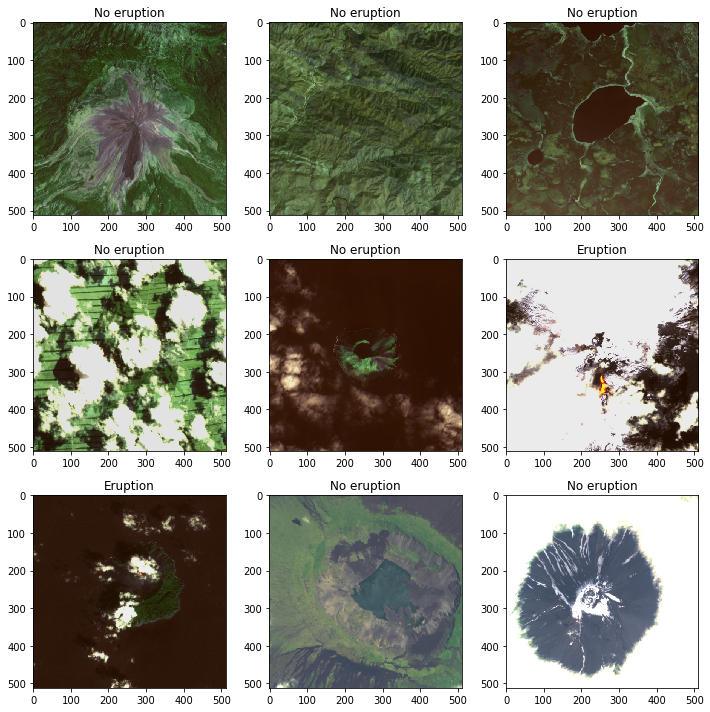

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10,10))
axes = axes.flatten()
for i in range(0,9):
  axes[i].imshow(np.clip(x[i,...], 0,1))
  if y[i] == 0:
    axes[i].set_title('No eruption')
  else:
    axes[i].set_title('Eruption')
fig.tight_layout()

In [ ]:
predicted_classes = np.zeros(16)
d = np.zeros((1,512,512,3))

for i in range(0, 16):
  
  img = process_image(x[i,...])
  d[0,...] = img
  
  predicted_classes[i] = big.predict(d)
  print('Predicted: ', predicted_classes[i], ' Real: ', y[i])

Predicted:  3.463693064986728e-05  Real:  0
Predicted:  0.0001717715640552342  Real:  0
Predicted:  1.6038185322031495e-06  Real:  0
Predicted:  0.0  Real:  0
Predicted:  0.2663979232311249  Real:  0
Predicted:  0.9999709129333496  Real:  1
Predicted:  0.9998685121536255  Real:  1
Predicted:  0.8882148265838623  Real:  0
Predicted:  0.01097071636468172  Real:  0
Predicted:  0.9714975953102112  Real:  1
Predicted:  0.7238368988037109  Real:  1
Predicted:  0.0025906527880579233  Real:  0
Predicted:  0.07161284983158112  Real:  0
Predicted:  0.9913199543952942  Real:  1
Predicted:  0.8761774897575378  Real:  1
Predicted:  0.000640413723886013  Real:  0
